<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# ARIMA Lab  


</br>  
</br>  
*Authors:*
 - Joseph Nelson (DC)      
 - Boom Devahastin Na Ayudhya  (NYC)   
 - Bethany Poulin (Boston) 



---

## Introduction


The most common application for AR, ARMA, and ARIMA models is inventory planning. Planning inventory for a small shop can be difficult enough, but you've just been hired to plan inventory for a _big_ store - Walmart.

In this lab, you will be analyzing weekly Walmart sales data over a two year period from 2010 to 2012. The data is separated by store and by department, but you should focus on analyzing one store for simplicity. Your supervisor has set out the following goals for this project:

1. Record any observed trends in the data.
2. Produce a trained model to predict future sales numbers.
3. Include useful AND COMMENT ON how graphs (ACF, PACF) impact your modelling decisions throughout your notebook.

Try your best to tune your model. It can be difficult, but don't worry - time series analysis is a difficult and specialized topic.

## Exercise
---

#### Requirements

- Assemble observations and graphs as well as timeseries models in a notebook.


#### Additional Resources

1. [ARMA Example](https://www.statsmodels.org/dev/examples/notebooks/generated/tsa_arma_0.html)
2. [ARMA Models for TSA](https://www.quantstart.com/articles/Autoregressive-Moving-Average-ARMA-p-q-Models-for-Time-Series-Analysis-Part-1)

#### Things to Consider

You should always be looking for ways to reduce redundancy in your code, improve consistency in your output, and make it easier for others to follow your work! Functions are a huge part of this endeavor!

While working on this lab, you may try a number of $p$, $q$, and $d$ values to best account for your data. Because you will likely be repeating yourself, it is useful to create functions that declutter your workspace.

 - You may want to create a wrapper around the Augmented Dickey-Fuller test to provide both results and context for the output.
 - You may find value in a combined ACF & PACF function.
 - You may find it cleaner to build a function to make residual graphs and print out MSE all at once.

### Importing Necessary Libraries & Loading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima_model import ARIMA, ARMA, AR
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller  
from sklearn.model_selection import train_test_split

%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

data = pd.read_csv('./datasets/train.csv')
data['Date'] = pd.to_datetime(data["Date"])
print(data.dtypes)
data.set_index('Date', inplace=True)
data.head(3)

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
dtype: object


,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False


## Exploratory Analysis

#### 0. Preprocessing Data
It's always a good idea to evaluate the current state of your data. For every set of data this means something different. But the bare minimum is understanding what types of data you have, knowing if there are missing values and checking to be sure that your date column (or index) is in a proper date format.

Accordingly you should check:
 - Format of date column/index
 - Data types for each column
 - Whether or not we will have to deal with missing data

In [2]:
# Checking the data types
data.dtypes

Store             int64
Dept              int64
Weekly_Sales    float64
IsHoliday          bool
dtype: object

In [3]:
data.shape

(421570, 4)

In [4]:
# Checking to see if there is missing data
data.isnull().sum()

Store           0
Dept            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [5]:
data.Store.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

#### 1. Extracting Data to Model

Our data set has a number of stores, each with weekly sales volumes for many departments. 

To facilitate our first time series model, we need to use a single store, and aggregate the total sales for all departments.

**Aggregate all of the sales for STORE 1 into a new dataframe called `Weekly_Sales`.**


In [6]:
store_1 = data.loc[data['Store'] == 1]
store_1.shape

(10244, 4)

In [7]:
store_1.Dept.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 40, 41, 42, 44, 45, 46, 47, 48, 49, 51, 52, 54, 55, 56,
       58, 59, 60, 67, 71, 72, 74, 77, 78, 79, 80, 81, 82, 83, 85, 87, 90,
       91, 92, 93, 94, 95, 96, 97, 98, 99])

In [8]:
Weekly_Sales = store_1.resample('W').sum()
Weekly_Sales.drop(columns=['Dept', 'Store', 'IsHoliday'], inplace=True)
Weekly_Sales.head(5)

,Weekly_Sales
Date,
2010-02-07,1643690.90
2010-02-14,1641957.44
2010-02-21,1611968.17
2010-02-28,1409727.59
2010-03-07,1554806.68


In [9]:
Weekly_Sales.index

DatetimeIndex(['2010-02-07', '2010-02-14', '2010-02-21', '2010-02-28',
               '2010-03-07', '2010-03-14', '2010-03-21', '2010-03-28',
               '2010-04-04', '2010-04-11',
               ...
               '2012-08-26', '2012-09-02', '2012-09-09', '2012-09-16',
               '2012-09-23', '2012-09-30', '2012-10-07', '2012-10-14',
               '2012-10-21', '2012-10-28'],
              dtype='datetime64[ns]', name='Date', length=143, freq='W-SUN')

#### 2. Plotting & Interpreting Time Series

Plots are a central part of all time series analysis. You should always start with a basic line plot.

**2a. Generate a line plot for `Weekly_Sales` with time on the $x$-axis.**

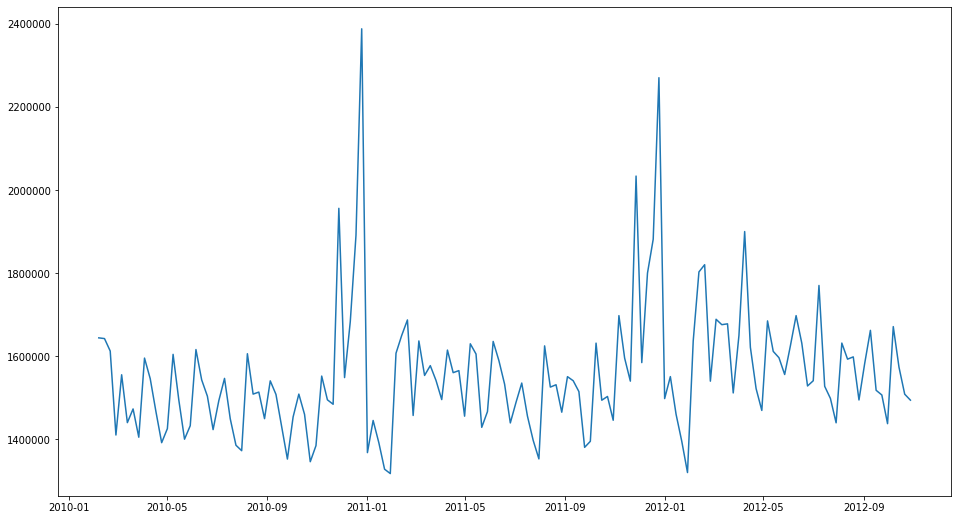

In [10]:
plt.figure(figsize=(16, 9))
plt.plot(Weekly_Sales['Weekly_Sales']);


Smoothing can help us see trends in the data. With time series, this frequently means plotting a rolling mean.

You might start looking at a one week roll, but you consider several 'windows' of time. 
 - What would a four week rolling mean look like? 
 - How about quarterly? 
 - Or annually? 

**2b. Calculate the rolling mean(s) for `Weekly_Sales` then plot them on a single set of axes.**

In [11]:
def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18);

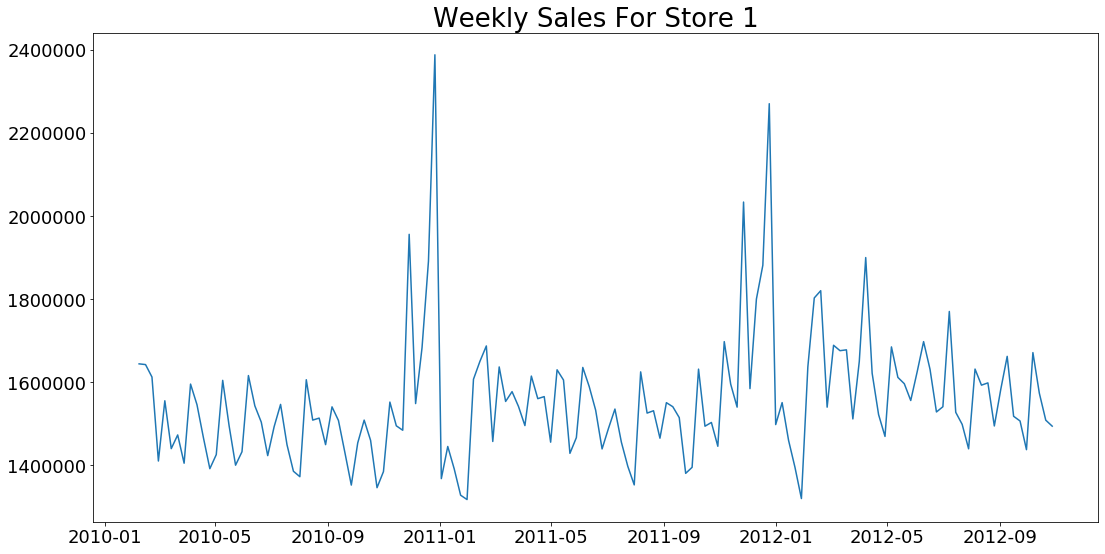

In [12]:
plot_series(Weekly_Sales, cols=['Weekly_Sales'], title='Weekly Sales For Store 1', steps=18)

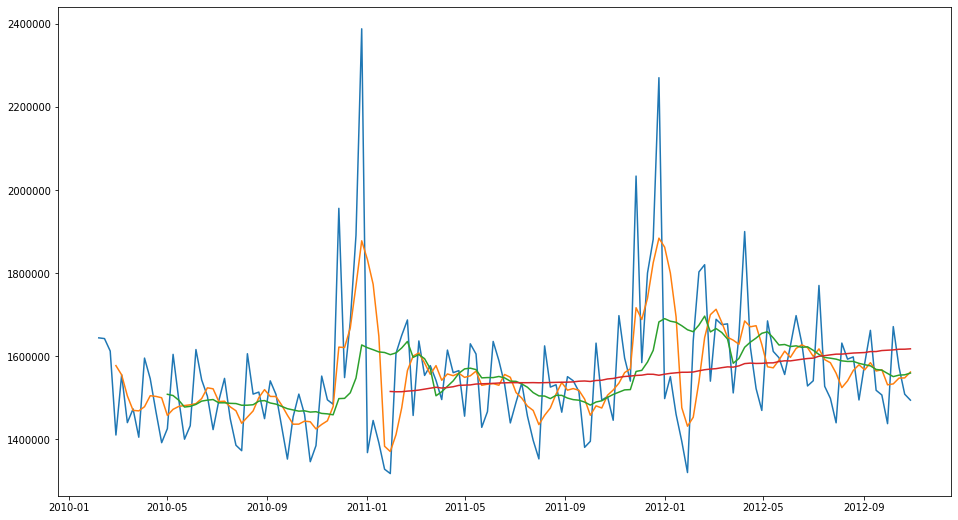

In [13]:
plt.figure(figsize=(16, 9))
plt.plot(Weekly_Sales['Weekly_Sales'])
plt.plot(Weekly_Sales['Weekly_Sales'].rolling(4).mean())
plt.plot(Weekly_Sales['Weekly_Sales'].rolling(13).mean())
plt.plot(Weekly_Sales['Weekly_Sales'].rolling(52).mean());

**2c. What can you say about trends in the data based on the rolling mean plot above?**

*Answer:* You can see that there is a slight trend upward in sales from an annual basis but there is likely seasonality in the data. YOu can see dramatic spikes around the new year and at various other points during the year

#### 3. Autocorrelations

We've learned about autocorrelation: the influence a serial observation has on the observations which follow.

Calculate autocorrelation in your `Weekly_Sales` data so that you can answer the question: 'How does autocorrelation differ as lag-weeks vary?'

**3a. Check at least three lag intervals (but feel free to explore others):**
 - **1 week**
 - **2 weeks**
 - **1 year (52 weeks)**

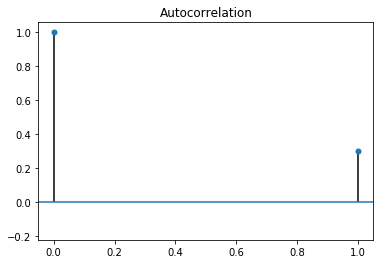

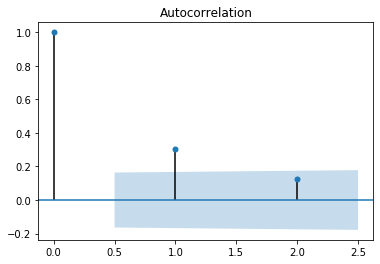

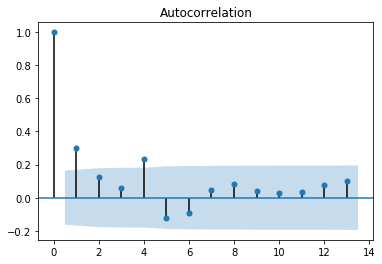

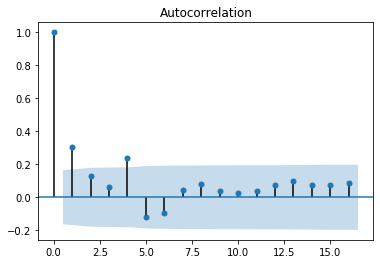

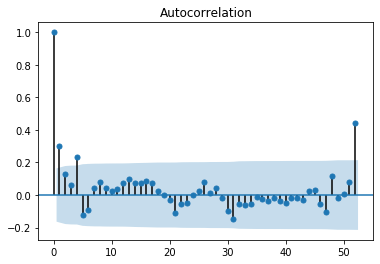

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(Weekly_Sales['Weekly_Sales'], lags=1)
plot_acf(Weekly_Sales['Weekly_Sales'], lags=2)
plot_acf(Weekly_Sales['Weekly_Sales'], lags=13)
plot_acf(Weekly_Sales['Weekly_Sales'], lags=16);
plot_acf(Weekly_Sales['Weekly_Sales'], lags=52);

**3b. What can you say about the series based on these autocorrelations?**

Answer: It seems like the correlation is strong from 1 week prior meaning that we would expect the sales of this week to be similar to the sales of last week $and$ we see a strong correlation with 4 weeks ago which might suggest that there is a strong correlation with when people get their paycheck. If someone gets paid once a month, then they will have more disposable income with which to spend on groceries and other household items. 

**3c. Plotting ACF and PCF**
As we learned in lecture, plotting the `Autocorrelation Function` and `Partial Autocorrelation Functions` can be useful in understanding seasonality in time series data.

Make a 52-week `ACF` and 52-week `PACF` plot now.

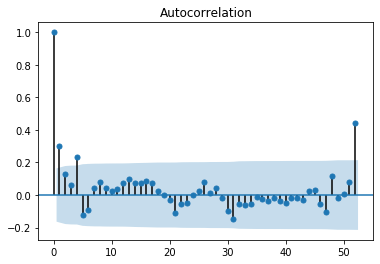

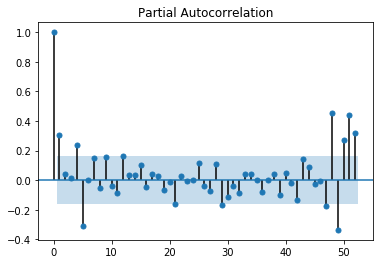

In [15]:
plot_acf(Weekly_Sales['Weekly_Sales'], lags=52)
plot_pacf(Weekly_Sales['Weekly_Sales'], lags=52);

#### 4. Interpreting the `ACF` and `PACF` Plots

**4a. What do the ACF and PACF graphs tell you about your sales data?**

Answer:

**4b. How do the `ACF` and `PACF` inform your model selections moving forward?**

Answer:

## Modeling

**5. Train/Test Split**  

Modeling with time series data presents unique challenges because our observations are not independent of one another. 

So, in splitting the data into `training` and `test` sets, **we cannot split randomly**. Use the first *75%* of observations as training data and the following 25% for test data.

In [176]:
X = Weekly_Sales.index
y = Weekly_Sales['Weekly_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

In [155]:
y_train.shape

(107,)

#### 6. Autoregressive Model

We will start by building a simple autoregressive model first: the `AR(1)` model. (*Note that this is the same thing as an ARIMA(1,0,0) model.*)

**6a. Instantiate and fit an `AR(1)` model.**

In [164]:
def create_arima(train, test, p, d, q, residual_plot=False):
    model_train = ARIMA(endog=train, order=(p, d, q))
    
    params = model_train.fit()
    preds_train = model_train.predict(params=params.params,
                         start=train.index[d],
                         end=train.index[-1],
                         exog=train.index)
    mse_train = mean_squared_error(train[d:], preds_train)
    
    #####
    preds_test = model_train.predict(params=params.params,
                         start=test.index[0],
                         end=test.index[-1],
                         exog=test.index)
    mse_test = mean_squared_error(test, preds_test)

    #######
    print(f'The Mean Squarred Error For Training Is: {mse_train}')
    print(f'The Mean Squarred Error For Testing Is: {mse_test}')
    
    plt.figure(figsize=(16, 9))
    plt.plot(train)
    plt.plot(test)
    plt.plot(test.index, preds_test, color = 'green')
    plt.plot(train.index[d:], preds_train, color = 'red')
    if residual_plot:
        plt.plot((test-preds_test), color = 'purple')

**6b. Calculate the Mean Squared Error of the `AR(1)` on your training set and your test set.**


The Mean Squarred Error For Training Is: 25903501211.287106
The Mean Squarred Error For Testing Is: 11108594685.235214


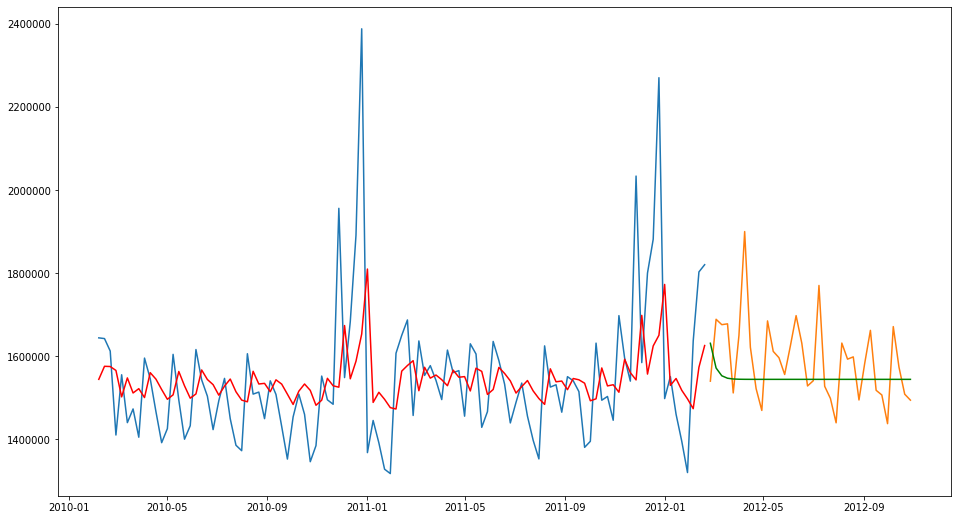

In [165]:
create_arima(y_train, y_test, 1, 0, 0)

**6c. How effective do you think this `AR(1)` model is?**

Answer: If you look at the green line above, it shows the predictions for y_test. These predictions look pretty poor. It doesn't seem like the model is doing a great job of accounting for variability from week to week but that it is probably predicting average sales pretty well. How you measure effectiveness if going to be pretty important here. 

#### 7. Residual Plot  
Mean squared error is a good way to evaluate our model's performance. However, this doesn't tell the whole story. Is our model off by a lot in one specific window of time? Is our model only slightly off, but over all time? It might be helpful to plot residuals to see when our model is off most.

**7a. Calculate and and plot the residuals of your `AR(1)` model. (*Remember that a residual is just the actual value minus the predicted value.*)**

The Mean Squarred Error For Training Is: 25903501211.287106
The Mean Squarred Error For Testing Is: 11108594685.235214


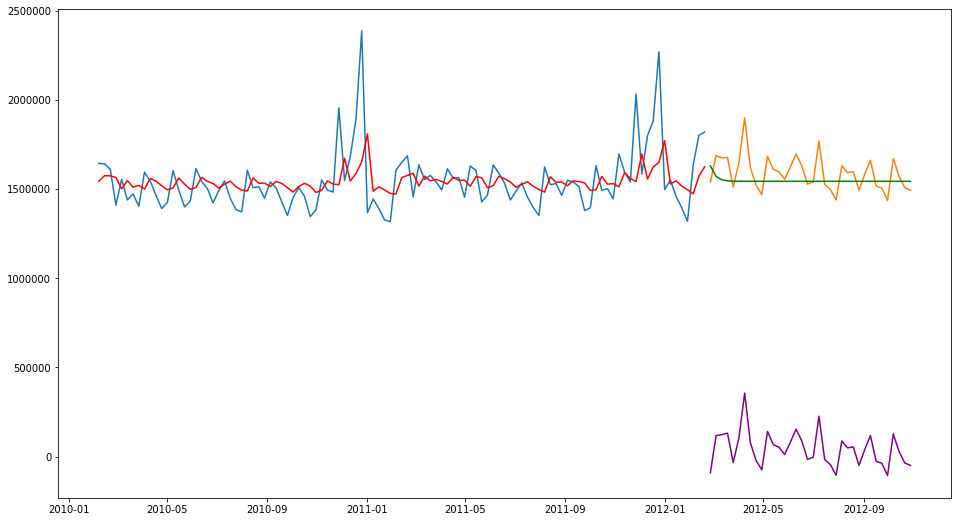

In [166]:
create_arima(y_train, y_test, 1, 0, 0, residual_plot=True)

From this plot we can see that there are clearly errors in our predictions. 

**7b. What do the residual plots reveal about our model?**

Answer: They show that the model isn't accounting for the Moving Average portion of the data. That is why the green line is flat. It can't predict into the future, thus our residuals are just replicating our actual data. As you can see the purple line (residuals) at the bottom is almost a match of the orange line. The predicted values in green are flat.

#### 8. AR vs. ARMA Models 


**8a. Let's fit an `AR(2)` model. Calculate the MSE on the training and testing sets, then plot the residuals.**

The Mean Squarred Error For Training Is: 25814330936.969418
The Mean Squarred Error For Testing Is: 10932675980.98504


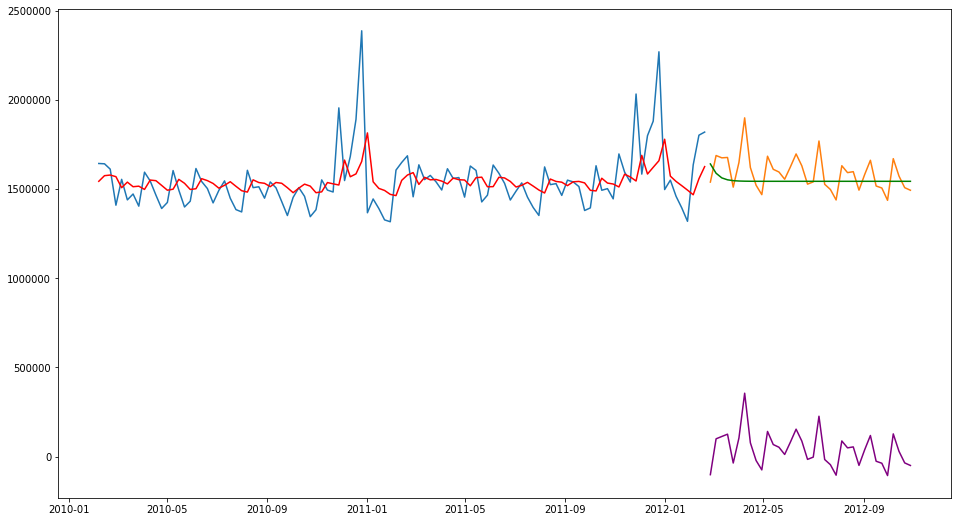

In [167]:
create_arima(y_train, y_test, 2, 0, 0, residual_plot=True)

**8b. How did your results change?**

Answer: My results didn't change significantly at all. The picture is basicall the same.

**8c. Fit an `ARMA(2,2)` model. Calculate the MSE on the training and testing sets, then plot the residuals.** (_Note that an `ARMA(2,2)` model is the same as an `ARIMA(2,0,2)` model._)

The Mean Squarred Error For Training Is: 21563487956.0263
The Mean Squarred Error For Testing Is: 11042412763.99598


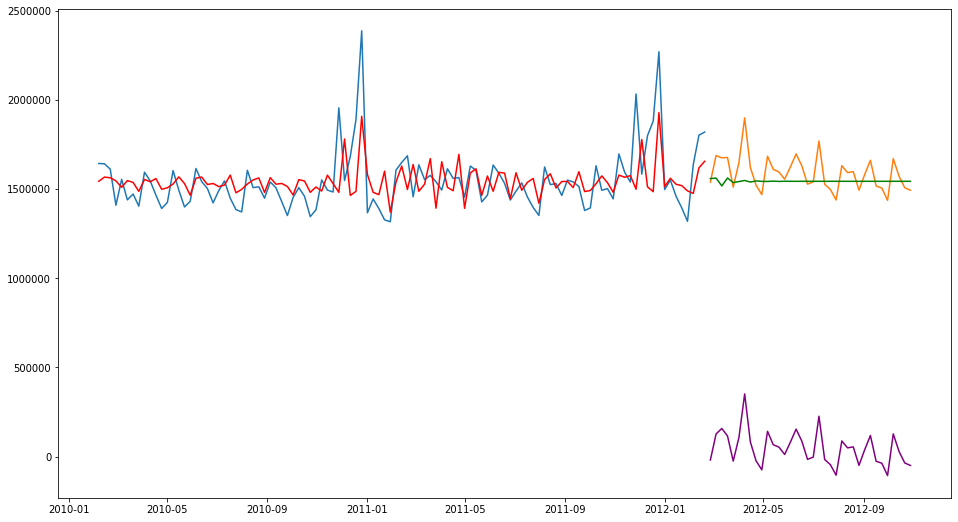

In [168]:
create_arima(y_train, y_test, 2, 0, 2, residual_plot=True)

**8d. How do the errors and residuals change from `AR(2)` to `ARMA(2,2)`?**



Answer: The MSE for the training set is decreased from AR(2) --> ARMA(2,2) however the testing set saw a slight increase in the MSE from AR(2) --> ARMA(2,2). The predictions seem to model the actual y_test data set better however in teh ARMA(2,2) model.

#### 9. Stationary Data

Remember that one assumption to using the ARIMA model is that our data are **stationary**. This is a necessary assumption for our model, and it is important for us to check for it whenever we fit a time series model.

**9a. Use the Augmented Dickey-Fuller test to estimate whether or not your data are stationary.**

In [169]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [170]:
interpret_dftest(adfuller(Weekly_Sales['Weekly_Sales']))

Test Statistic   -5.102186
p-value           0.000014
dtype: float64

**9b. Interpret the results of the Augmented Dickey-Fuller test.**

Answer: Since the p-vale is below 0.05 we can accept the null hypothesis that our data are stationary

#### 10. Differenced Data

**10a. Create new columns in your `Weekly_Sales` dataframe.**
- One column should be `Weekly_Sales` differenced by 1 time period.
- Another column should be `Weekly_Sales` differenced by 2 time periods.
- Another column should be `Weekly_Sales` differenced by 3 time periods.
- Another column should be `Weekly_Sales` differenced by 4 time periods.

In [171]:
Weekly_Sales['first_diff_sales'] = Weekly_Sales['Weekly_Sales'].diff(1)
Weekly_Sales['second_diff_sales'] = Weekly_Sales['Weekly_Sales'].diff(1).diff(1)
Weekly_Sales['third_diff_sales'] = Weekly_Sales['Weekly_Sales'].diff(1).diff(1).diff(1)
Weekly_Sales['fourth_diff_sales'] = Weekly_Sales['Weekly_Sales'].diff(1).diff(1).diff(1).diff(1)
Weekly_Sales.head(5)

,Weekly_Sales,first_diff_sales,second_diff_sales,third_diff_sales,fourth_diff_sales
Date,,,,,
2010-02-07,1643690.90,NaN,NaN,NaN,NaN
2010-02-14,1641957.44,-1733.46,NaN,NaN,NaN
2010-02-21,1611968.17,-29989.27,-28255.81,NaN,NaN
2010-02-28,1409727.59,-202240.58,-172251.31,-143995.50,NaN
2010-03-07,1554806.68,145079.09,347319.67,519570.98,663566.48


**10b. Conduct and interpret the Augmented Dickey-Fuller test on each differenced column to test for stationarity.**

In [172]:
print(f'First Differenced ADF Test: {interpret_dftest(adfuller(Weekly_Sales["first_diff_sales"].dropna()))}')
print(f'Second Differenced ADF Test: {interpret_dftest(adfuller(Weekly_Sales["second_diff_sales"].dropna()))}')
print(f'Third Differenced ADF Test: {interpret_dftest(adfuller(Weekly_Sales["third_diff_sales"].dropna()))}')
print(f'Fourth Differenced ADF Test: {interpret_dftest(adfuller(Weekly_Sales["fourth_diff_sales"].dropna()))}')

First Differenced ADF Test: Test Statistic   -7.261575e+00
p-value           1.676180e-10
dtype: float64
Second Differenced ADF Test: Test Statistic   -6.517398e+00
p-value           1.062879e-08
dtype: float64
Third Differenced ADF Test: Test Statistic   -6.858902e+00
p-value           1.621469e-09
dtype: float64
Fourth Differenced ADF Test: Test Statistic   -7.786634e+00
p-value           8.146853e-12
dtype: float64


**10c. For which (if any) of the columns does it seem meaningful to have differenced the data?**

Answer: They do not see to have had a meaningful effect on the data. The p-value was already statistically significant before differencing. 

**10d. Based on these tests and the ACF/PACF plots above, do you think that using an Integrated AutoRegressive Moving Average (ARIMA) model makes sense? Why or why not?**

Answer:

#### 11.  ARIMA MODEL

Based on your interpretation of the results from your tests for stationarity, and information gleaned from your ACF and PACF plots, choose a value of `d` to use in the `ARIMA(2,d,2)`.

**11a. Fit an `ARIMA(2,d,2)` model for the value of `d` you have chosen. Evaluate your model on the training and testing sets and generate a residual plot.**

In [173]:
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
y_train['first_diff_sales'] = y_train['Weekly_Sales'].diff(1)
y_train['second_diff_sales'] = y_train['Weekly_Sales'].diff(1).diff(1)
y_train['third_diff_sales'] = y_train['Weekly_Sales'].diff(1).diff(1).diff(1)
y_train['fourth_diff_sales'] = y_train['Weekly_Sales'].diff(1).diff(1).diff(1).diff(1)
y_test['first_diff_sales'] = y_test['Weekly_Sales'].diff(1)
y_test['second_diff_sales'] = y_test['Weekly_Sales'].diff(1).diff(1)
y_test['third_diff_sales'] = y_test['Weekly_Sales'].diff(1).diff(1).diff(1)
y_test['fourth_diff_sales'] = y_test['Weekly_Sales'].diff(1).diff(1).diff(1).diff(1)

In [174]:
y_train.head(2)

,Weekly_Sales,first_diff_sales,second_diff_sales,third_diff_sales,fourth_diff_sales
Date,,,,,
2010-02-07,1643690.90,NaN,NaN,NaN,NaN
2010-02-14,1641957.44,-1733.46,NaN,NaN,NaN


The Mean Squarred Error For Training Is: 2433930315699.5513
The Mean Squarred Error For Testing Is: 2530918014731.0137


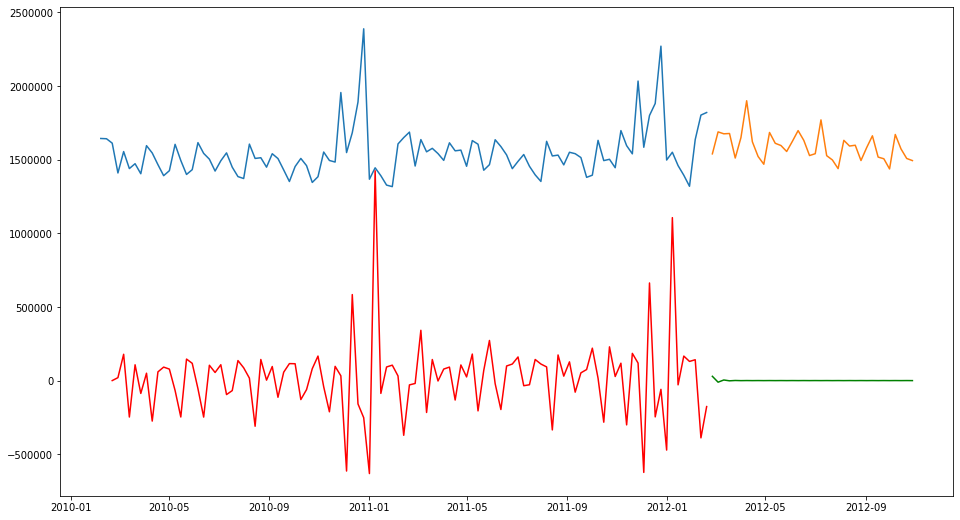

In [177]:
create_arima(y_train, y_test, 2, 2, 2, residual_plot=False)

**11b. Interpret the results from the last answer.**


Answer: YOu can see that 

#### 12.  SARIMAX Model
We have looked at autocorrelation of neighboring values (i.e. comparing $Y_t$ to $Y_{t-1}$ or $Y_t$ to $Y_{t-4}$). However, what about seasonal affects on our data? How might the sales today be related to sales 6 months ago or a year ago?

Let's build a SARIMAX model!

**12a. Using `PACF` and `ACF` plots with appropriate intervals (think months in a year) try to build the best SARIMAX model you can in setting the `seasonal_order = (P, D, Q, S)` and using `order = (2, 0, 2)`, fit and evaluate the model as we have done in the prior models**.

In [105]:
y_train.head(2)

Date
2010-02-07    1643690.90
2010-02-14    1641957.44
Freq: W-SUN, Name: Weekly_Sales, dtype: float64

In [87]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

Mean squarred error: 4744560401.383075


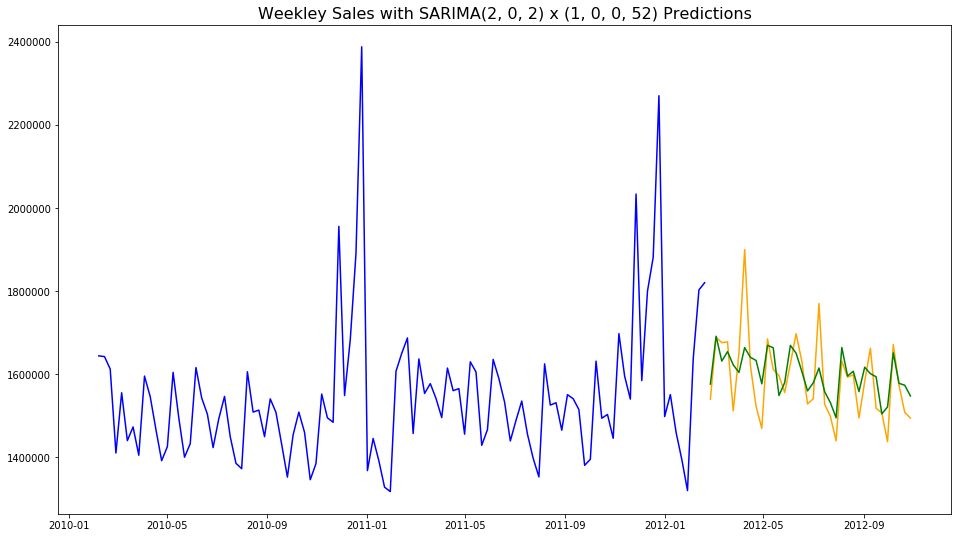

In [103]:
sarima = SARIMAX(endog = y_train,
                 order = (2, 0, 2),              # (p, d, q)
                 seasonal_order = (1, 0, 0, 52)) # (P, D, Q, S)

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
preds = model.predict(start=y_test.index[0],
                      end=y_test.index[-1])

# Evaluate predictions.
print(f'Mean squarred error: {mean_squared_error(y_test, preds)}')

# Plot data.
plt.figure(figsize=(16,9))
plt.plot(y_train, color = 'blue')
plt.plot(y_test, color = 'orange')
plt.plot(preds, color = 'green')
plt.title(label = 'Weekley Sales with SARIMA(2, 0, 2) x (1, 0, 0, 52) Predictions', fontsize=16)
plt.show();

**12b. How did your best SARIMAX model perform?**

Answer: The SARIMAX Model scored the best on the MSE with a value of: $4,744,560,401.38

### 13. Your Best Model

**13a. In the cells below, bring together your best model, including:**
- any summaries, 
- graphs of the data and residuals, 
- the predictions,
- and how you decided this was your best model.

**13b. How does our model perform at predicting weekly sales moving forward?** 

Answer: 

**13c. How might you improve it?**

Answer:

### 14. BONUS: Rolling Predictions

**Try testing the performance of your model using rolling predictions. For each testing observation $Y_t$ you should train your model using data up to $Y_{t-1}$. This allows us to make meaningful predictions for all testing observations** 

Answer: